In [119]:
import openturns as ot
import matplotlib.pyplot as plt
import numpy as np
import math
ot.RandomGenerator.SetSeed(42)

# ======================================== Fonction de plot ========================================
def plot_field(field, mode="plot", ax=None, title=None, vmin=None, vmax=None, add_colorbar=True):
    mesh = field.getMesh()

    x = mesh.getVertices().getMarginal(0)
    y = mesh.getVertices().getMarginal(1)
    z = field.getValues()

    x_unique = np.unique(x)
    y_unique = np.unique(y)
    nx = len(x_unique)
    ny = len(y_unique)

    X = np.array(x).reshape(ny, nx)
    Y = np.array(y).reshape(ny, nx)
    Z = np.array(z).reshape(ny, nx)

    if mode == "plot":
        fig, ax_local = plt.subplots(figsize=(6, 4))
    elif mode == "subplot":
        if ax is None:
            raise ValueError("En mode 'subplot', fournir un axe via le paramètre ax.")
        fig, ax_local = ax.figure, ax
    else:
        raise ValueError("mode doit être 'plot' ou 'subplot'.")

    contour = ax_local.contourf(X, Y, Z, levels=15, vmin=vmin, vmax=vmax)
    if add_colorbar:
        fig.colorbar(contour, ax=ax_local)
    if title:
        ax_local.set_title(title)

    return fig, ax_local, contour


# ======================== Maillage & Transformation par sigmoïde ========================
mesher = ot.IntervalMesher([50, 50])
mesh = mesher.build(ot.Interval([0.0, 0.0], [2.0, 2.0]))
sigmoid = ot.SymbolicFunction(['z'], ['1/(1+exp(-z))'])
field_function = ot.PythonFieldFunction(mesh, 1, mesh, 1, sigmoid)


### Tests de différents hyperparamètres

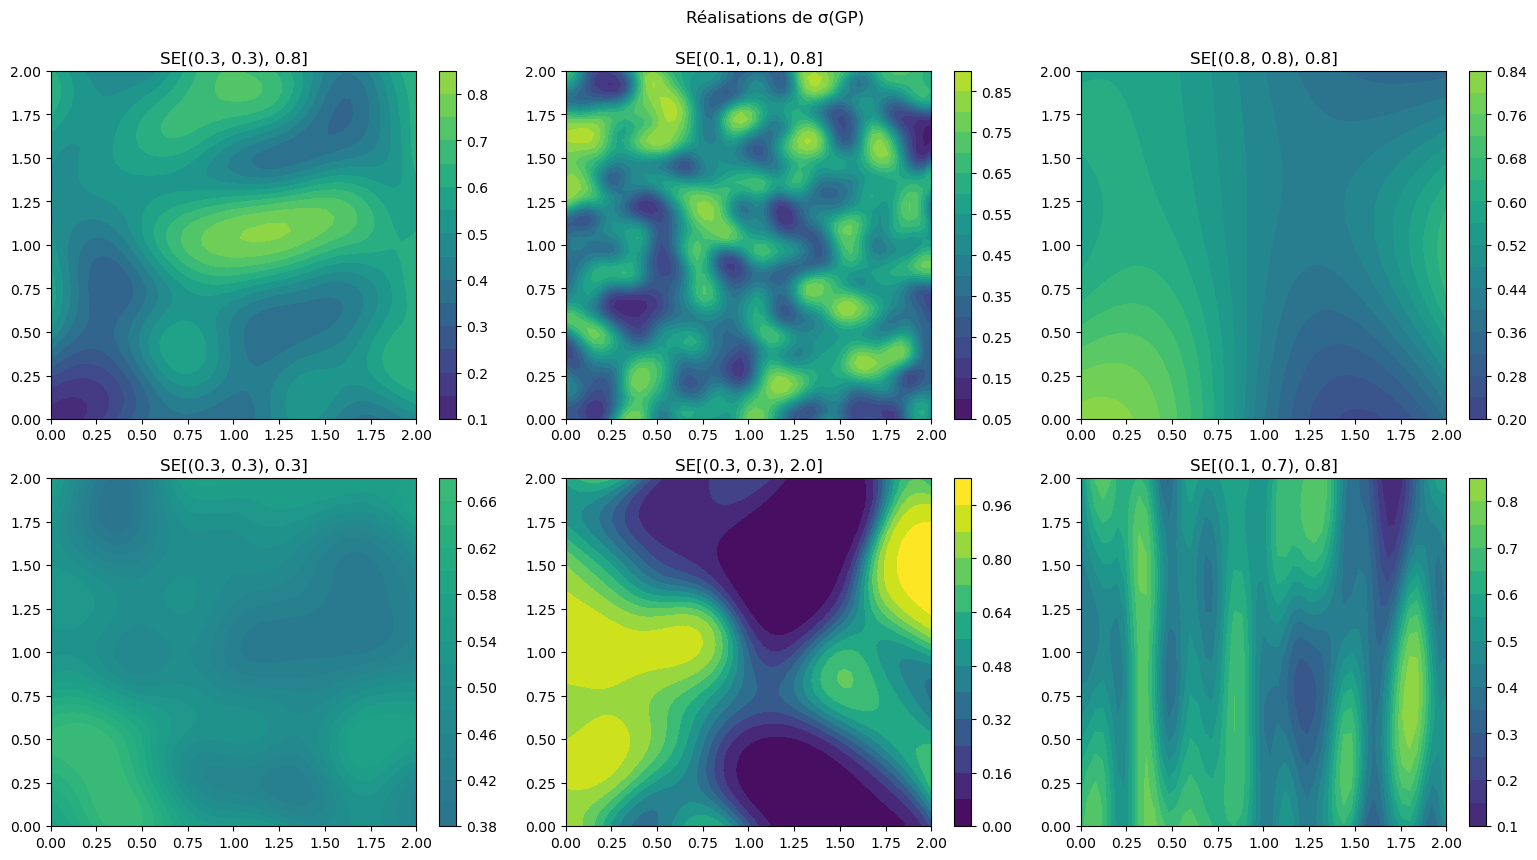

In [120]:
# Grille d'hyperparamètres du noyau SE : ([lx, ly], amplitude)
param_grid = [
    ([0.3, 0.3], 0.8),    # référence
    ([0.1, 0.1], 0.8),    # plus rugueux
    ([0.8, 0.8], 0.8),    # plus lisse
    ([0.3, 0.3], 0.3),    # amplitude plus faible
    ([0.3, 0.3], 2.0),    # amplitude plus forte
    ([0.1, 0.7], 0.8),    # anisotrope
]

fields = []
for scales, amp in param_grid:
    cov = ot.SquaredExponential(scales, [amp])
    gp = ot.GaussianProcess(cov, mesh)
    process = ot.CompositeProcess(field_function, gp)
    fields.append((process.getRealization(), scales, amp))

# Bornes de couleurs communes pour comparaison cohérente
all_vals = np.concatenate([np.array(f[0].getValues()).ravel() for f in fields])
zmin, zmax = float(np.min(all_vals)), float(np.max(all_vals))

# Grille de subplots
n = len(fields)
ncols = min(3, n)
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(5.2*ncols, 4.3*nrows), squeeze=False)
axes_flat = axes.ravel()

for i, (field_f, scales, amp) in enumerate(fields):
    fig, ax_i, _ = plot_field(
        field_f,
        mode="subplot",
        ax=axes_flat[i],
        title=f"SE[({scales[0]}, {scales[1]}), {amp}]",
        vmin=zmin, vmax=zmax,
        add_colorbar=True
    )

# Masquer axes inutilisés
for ax in axes_flat[n:]:
    ax.axis('off')

fig.suptitle("Réalisations de σ(GP)", y=0.995)
plt.tight_layout()
plt.show()


(<Figure size 600x400 with 2 Axes>,
 <Axes: >,
 <matplotlib.contour.QuadContourSet at 0x337b14ec0>)

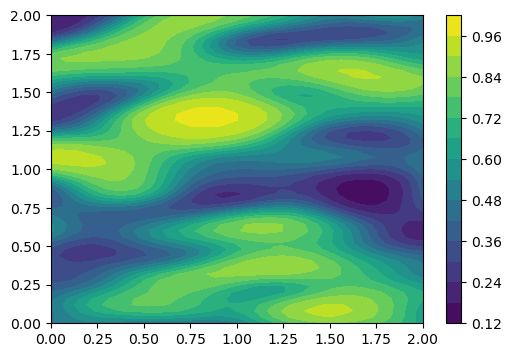

In [123]:
# Create mesh 
mesher = ot.IntervalMesher([50, 50]) 
mesh = mesher.build(ot.Interval([0.0, 0.0], [2.0, 2.0])) 

cov = ot.SquaredExponential([0.35, 0.12], [1.0]) 
X = ot.GaussianProcess(cov, mesh)

sigmoid = ot.SymbolicFunction(['z'], ['1/(1+exp(-z))']) 
field_function = ot.PythonFieldFunction(mesh, 1, mesh, 1, sigmoid) 
process = ot.CompositeProcess(field_function, X) 

# Plot a realization of the composite process 
field_f = process.getRealization() 
plot_field(field_f)

### Ajout d'une moyenne dans le GP

(<Figure size 600x400 with 2 Axes>,
 <Axes: >,
 <matplotlib.contour.QuadContourSet at 0x358190440>)

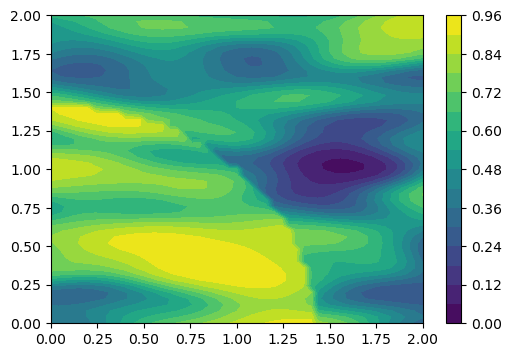

In [125]:
# Create mesh
mesher = ot.IntervalMesher([50, 50])
mesh = mesher.build(ot.Interval([0.0, 0.0], [2.0, 2.0]))

def tend(X):
    return [X[0]**2 + X[1]**2 <= 2.0]

f = ot.PythonFunction(2, 1, tend)
fTrend = ot.TrendTransform(f, mesh)

cov = ot.SquaredExponential([0.35, 0.12], [1.0])
X = ot.GaussianProcess(fTrend ,cov, mesh)

sigmoid = ot.SymbolicFunction(['z'], ['1/(1+exp(-z))'])
field_function = ot.PythonFieldFunction(mesh, 1, mesh, 1, sigmoid)
process = ot.CompositeProcess(field_function, X)

# Plot a realization of the composite process
field_f = process.getRealization()
plot_field(field_f)

### Ajout du zonage dans la moyenne 

Aiire du polygone P1 : 0.0741
Aiire du polygone P2 : 0.2855
Aiire du polygone P3 : 0.1362
Aiire du polygone P4 : 0.7064
Aiire du polygone P5 : 0.4178
Aiire du polygone P6 : 0.2462
Aiire du polygone P7 : 0.2520
Aiire du polygone P8 : 0.1560
Aiire du polygone P9 : 0.3490


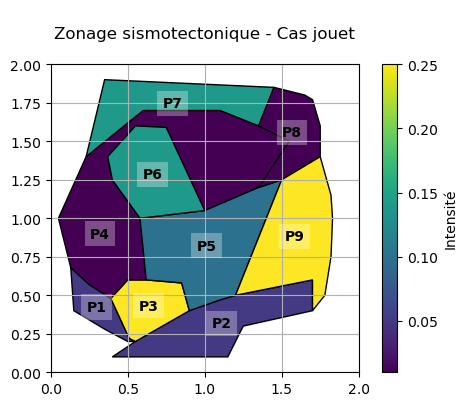

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
from matplotlib.colors import Normalize

# Polygones dans [0,2]²
polygons = [
    Polygon([(0.5,0.2), (0.55,0.2), (0.51,0.22), (0.39,0.48), (0.25,0.57), (0.13,0.68), (0.15,0.4), (0.35,0.28)]),
    Polygon([(0.4,0.1), (1.15,0.1), (1.25,0.3), (1.7,0.4), (1.7,0.6), (1.2,0.5), (1.1,0.47), (0.9,0.4), (0.55,0.2)]),
    Polygon([(0.55,0.2), (0.9,0.4), (0.85,0.58), (0.62,0.6), (0.5,0.6), (0.39,0.48), (0.51,0.22), (0.55,0.2)]),
    Polygon([(0.13,0.68), (0.25,0.57), (0.39,0.48), (0.5,0.6), (0.62,0.6), (0.58,1.0), (0.4,1.25), (0.37,1.4), (0.55,1.6), 
             (0.75,1.59), (1.0,1.05), (1.35,1.2), (1.55,1.5), (1.35,1.6), (1.1, 1.7), (0.6,1.7), (0.23,1.4), (0.05,1.0)]),
    Polygon([(0.62,0.6), (0.85,0.58), (0.9,0.4), (1.1,0.47), (1.2,0.5), (1.5,1.25), (1.35,1.2), (1.0,1.05), (0.58,1.0)]),
    Polygon([(0.58,1.0), (1.0,1.05), (0.75,1.59), (0.55,1.6), (0.37,1.4), (0.4,1.25)]),
    Polygon([(0.23,1.4), (0.35,1.9), (1.45,1.85), (1.35,1.6), (1.1, 1.7), (0.6,1.7), (0.23,1.4)]),
    Polygon([(1.45,1.85), (1.35,1.6), (1.55,1.5), (1.35,1.2), (1.5,1.25), (1.75,1.4), (1.75,1.6), (1.7,1.77), (1.65,1.80)]),
    Polygon([(1.5,1.25), (1.2,0.5), (1.7,0.6), (1.7,0.4), (1.78,0.5), (1.82,0.75), (1.83,1.0), (1.82,1.15), (1.75,1.4)])
]

# Intensités (poids de zone)
zone_weights = np.array([0.05, 0.05, 0.25, 0.01, 0.1, 0.14, 0.14, 0.01, 0.25]) 
cmap = plt.cm.viridis
norm = Normalize(vmin=zone_weights.min(), vmax=zone_weights.max())

# Calcul des aires
areas = np.array([poly.area for poly in polygons])
for i, area in enumerate(areas, 1):
    print(f"Aiire du polygone P{i} : {area:.4f}")


# =========================================== Affichage ===========================================
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_aspect('equal')

for i, (poly, intensity) in enumerate(zip(polygons, zone_weights), start=1):
    color = cmap(norm(intensity))
    patch = plt.Polygon(list(poly.exterior.coords), facecolor=color, edgecolor='black')
    ax.add_patch(patch)

    # Position du label
    if i == 4:
        label_x, label_y = 0.32, 0.9  # Coordonnées choisies manuellement pour P4
    else:
        centroid = poly.centroid
        label_x, label_y = centroid.x, centroid.y

    ax.text(label_x, label_y, f'P{i}', color='black', weight='bold',
            ha='center', va='center', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.3, edgecolor='none'))

# Colorbar et finalisation
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax, label="Intensité")
plt.title("\nZonage sismotectonique - Cas jouet\n")
plt.grid(True)
plt.show()
#fig.savefig("visualizations/figures/figure_zonage_cas_jouet.png")

(<Figure size 600x400 with 2 Axes>,
 <Axes: >,
 <matplotlib.contour.QuadContourSet at 0x3586b8bc0>)

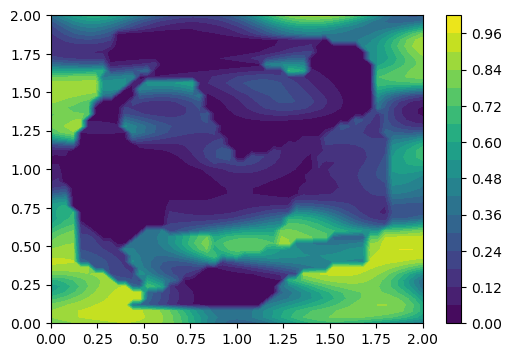

In [140]:
import openturns as ot
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, Point
from shapely.prepared import prep

polygons = [
    Polygon([(0.5,0.2), (0.55,0.2), (0.51,0.22), (0.39,0.48), (0.25,0.57), (0.13,0.68), (0.15,0.4), (0.35,0.28)]),
    Polygon([(0.4,0.1), (1.15,0.1), (1.25,0.3), (1.7,0.4), (1.7,0.6), (1.2,0.5), (1.1,0.47), (0.9,0.4), (0.55,0.2)]),
    Polygon([(0.55,0.2), (0.9,0.4), (0.85,0.58), (0.62,0.6), (0.5,0.6), (0.39,0.48), (0.51,0.22), (0.55,0.2)]),
    Polygon([(0.13,0.68), (0.25,0.57), (0.39,0.48), (0.5,0.6), (0.62,0.6), (0.58,1.0), (0.4,1.25), (0.37,1.4), (0.55,1.6), 
             (0.75,1.59), (1.0,1.05), (1.35,1.2), (1.55,1.5), (1.35,1.6), (1.1, 1.7), (0.6,1.7), (0.23,1.4), (0.05,1.0)]),
    Polygon([(0.62,0.6), (0.85,0.58), (0.9,0.4), (1.1,0.47), (1.2,0.5), (1.5,1.25), (1.35,1.2), (1.0,1.05), (0.58,1.0)]),
    Polygon([(0.58,1.0), (1.0,1.05), (0.75,1.59), (0.55,1.6), (0.37,1.4), (0.4,1.25)]),
    Polygon([(0.23,1.4), (0.35,1.9), (1.45,1.85), (1.35,1.6), (1.1, 1.7), (0.6,1.7), (0.23,1.4)]),
    Polygon([(1.45,1.85), (1.35,1.6), (1.55,1.5), (1.35,1.2), (1.5,1.25), (1.75,1.4), (1.75,1.6), (1.7,1.77), (1.65,1.80)]),
    Polygon([(1.5,1.25), (1.2,0.5), (1.7,0.6), (1.7,0.4), (1.78,0.5), (1.82,0.75), (1.83,1.0), (1.82,1.15), (1.75,1.4)])
]
zone_weights = np.array([0.05, 0.05, 0.25, 0.01, 0.1, 0.14, 0.14, 0.01, 0.25]) 
areas = np.array([poly.area for poly in polygons])
Zones = [(prep(p), float(w), float(a)) for p, w, a in zip(polygons, zone_weights, areas)]

mesher = ot.IntervalMesher([50, 50])
mesh = mesher.build(ot.Interval([0.0, 0.0], [2.0, 2.0]))

def tend(X):
    x, y = float(X[0]), float(X[1])
    pt = Point(x, y)
    for P, w, a in Zones:
        if P.covers(pt):
            return [-np.log((1/w)-1)]             
    return [0.0]

f = ot.PythonFunction(2, 1, tend)
fTrend = ot.TrendTransform(f, mesh)
cov = ot.SquaredExponential([0.35, 0.12], [1.8])
X = ot.GaussianProcess(fTrend, cov, mesh)

sigmoid = ot.SymbolicFunction(['z'], ['1/(1+exp(-z))'])
field_function = ot.PythonFieldFunction(mesh, 1, mesh, 1, sigmoid)
process = ot.CompositeProcess(field_function, X)

field_f = process.getRealization()
plot_field(field_f)


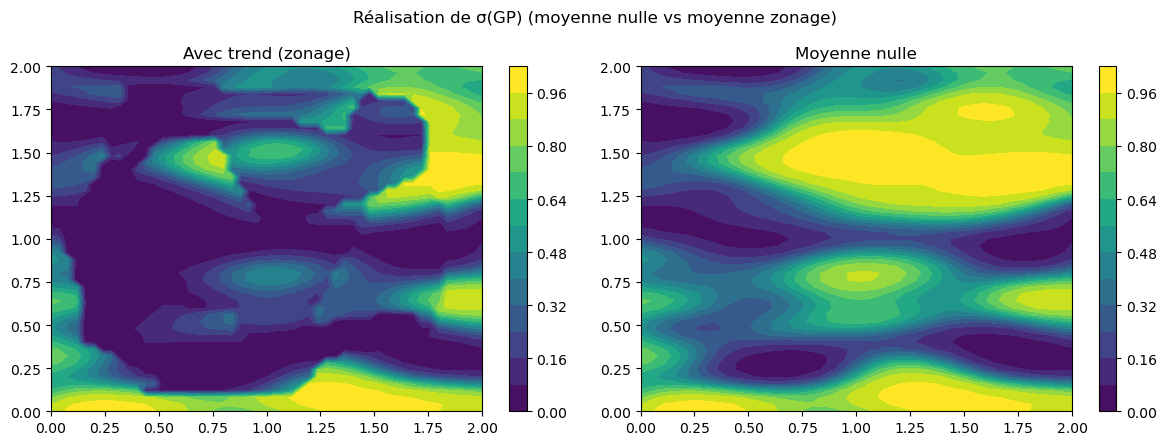

In [ ]:
# Avec trend (zonage)
X_trend = ot.GaussianProcess(fTrend, cov, mesh)
process_trend = ot.CompositeProcess(field_function, X_trend)

# Moyenne nulle
X_zero = ot.GaussianProcess(cov, mesh)
process_zero = ot.CompositeProcess(field_function, X_zero)

# Noyau fixe pour comparaison 
seed = 123
ot.RandomGenerator.SetSeed(seed)
field_trend = process_trend.getRealization()
ot.RandomGenerator.SetSeed(seed)
field_zero  = process_zero.getRealization()


fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
vmin, vmax = 0.0, 1.0

plot_field(field_trend, mode="subplot", ax=axes[0],
           title="Avec trend (zonage)", vmin=vmin, vmax=vmax, add_colorbar=True)

plot_field(field_zero,  mode="subplot", ax=axes[1],
           title="Moyenne nulle", vmin=vmin, vmax=vmax, add_colorbar=True)

fig.suptitle("Réalisation de σ(GP) (moyenne nulle vs moyenne zonage)", y=0.98)
plt.tight_layout()
plt.show()
